# Model 1
We therefore built a logistic regression model (inherent properties model) to predict the probability P($a_i=1$) that a biobank $i$ will be top-tier ($h$-index is an outlier of the distribution) two years after its publication:


$$
 \text{log}\frac{P(a_i=1)}{1- P(a_i=1)} \propto \beta_1 \times n_i + \beta_2 \times d_i + \beta_3 \times k_i + \beta_4 \times g_i + \beta_5 \times p_i.
$$

Given its cohort size (in logarithmic space, $n_i$), data availability $d_i$, kind $k_i$ (1 for population based, 0 for health-system based), genetic data availability $g_i$ (yes/no), and purpose $p_i$ (1 for general purpose, 0 for disease specific).

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Let's use only cohorts with intrinsic characteristics data

In [2]:
old_cohort = pd.read_csv('../../small_data/processed/old_cohort.csv', dtype={'year': 'int'})

In [4]:
old_cohort.shape

(259, 47)

In [9]:
big_cohort = pd.read_csv('../../small_data/processed/cohort3.csv')[['PaperId', 'Hindex']]
big_cohort.columns = big_cohort.columns.str.lower()

In [11]:
old_cohort = old_cohort.merge(big_cohort, how='left')

## Response Variable

This will be 1 for outlier biobanks and 0 for the rest.

In [3]:
old_cohort['outlier1'] = 0
q75 = old_cohort['h_index2'].quantile(.75)
q25 = old_cohort['h_index2'].quantile(.25)
old_cohort.loc[old_cohort['h_index2'] >= 1.5 * (q75 - q25), 'outlier1'] = 1

In [12]:
old_cohort['outlier1'] = 0
q75 = old_cohort['h_index'].quantile(.75)
q25 = old_cohort['h_index'].quantile(.25)
old_cohort.loc[old_cohort['h_index'] >= 1.5 * (q75 - q25), 'outlier1'] = 1

## Let's balance the sample

In [14]:
features = [
    'N',
    'data',
    'kind',
    'genetic',
    'general_purpose']

c = old_cohort.copy()

cohort_t = c[features + ['outlier1']].copy().dropna()

cohort_t['N'] = np.log10(cohort_t['N'])

cohort_t['data'] = cohort_t['data'].replace({'open': 1,
                                     'application': 1,
                                     'collaboration': 0,
                                     'fee': 0,
                                     'institution': 0})

cohort_t['kind'] = cohort_t['kind'].replace({'population': 1,
                                             'health': 0})

X, y = cohort_t[features].values, cohort_t['outlier1'].values

scaler = MinMaxScaler()

X = scaler.fit_transform(X)

## Balance the model based on the proportion of each class

In [46]:
prop_0 = cohort_t['outlier1'].value_counts(normalize=True).loc[0]
prop_1 = cohort_t['outlier1'].value_counts(normalize=True).loc[1]

clf = LogisticRegression(class_weight={0: 1, 1: 0.1}, C=2)

scores = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
cv_results = cross_validate(clf, X, y, cv=10, return_estimator=True)

print(f"The mean AUC for this model is {np.mean(scores)}")

The mean AUC for this model is 0.6300925925925925


## Let's get the mean coefficients for each variable

In [16]:
C = []
for est in cv_results['estimator']:
    C.append(est.coef_)
C = np.concatenate(C)
coef = np.mean(C, axis=0)
coef = pd.DataFrame([coef], columns=features)
coef

,N,data,kind,genetic,general_purpose
0,0.709432,-0.247184,0.266778,0.846708,0.364914


In [17]:
cv_results['estimator'][0].predict_proba(scaler.transform([[4, 0, 1, 0, 1]]))

array([[0.54277076, 0.45722924]])

In [18]:
cv_results['estimator'][0].predict_proba(scaler.transform([[4, 0, 1, 1, 1]]))

array([[0.32567809, 0.67432191]])

In [19]:
cv_results['estimator'][0].predict_proba(scaler.transform([[5, 1, 1, 0, 0]]))

array([[0.69779602, 0.30220398]])

### And a small plot

In [14]:
coef.columns = ['Sample\nSize', 'Open Data', 'Population\nBased', 'Genetic\nData', 'General\nPurpose']

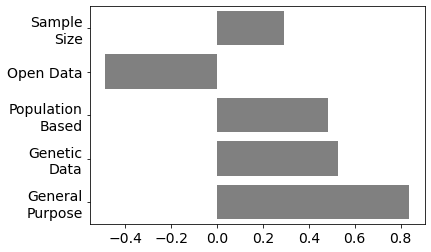

In [22]:
ax = sns.barplot(data=coef, orient='h', color='gray')
ax.set_ylabel('Model Coefficent')
ax.set_ylabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.xticks(rotation=0);